X = [1, 2, 3, 4, 5]
Y = [2, 3, 4, 5, 6]



Dict{Symbol, Any} with 8 entries:
  :α         => 0.05
  :p         => 0.5
  :df        => 8.0
  :phat      => 0.68
  :sehat     => 0.181108
  :tvalue    => 0.993884
  :pvalue    => 0.349386
  :confint_p => (0.262365, 1.09764)


phat = 0.68
ahat = 1.0
α = 0.05
ci_p = [0.2623648885, 1.097635111]
ci_a = [-1.0, 3.0]



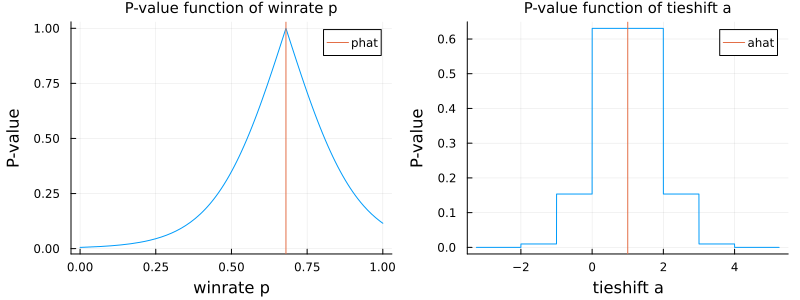

In [1]:
using Distributions
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10)

r(x) = round(x; sigdigits=10)

winrate(X, Y) = mean((x < y) + (x == y)/2 for x in X, y in Y)

function brunner_munzel_test(X, Y; p=1/2, α=0.05)
    phat = winrate(X, Y)
    m, n = length(X), length(Y)
    Hbarx = n*(1 - phat)
    Hbary = m*phat
    sx2 = 1/n^2 * 1/(m-1) * sum(x -> (sum((y < x) + (y == x)/2 for y in Y) - Hbarx)^2, X)
    sy2 = 1/m^2 * 1/(n-1) * sum(y -> (sum((x < y) + (x == y)/2 for x in X) - Hbary)^2, Y)
    sehat = √(sx2/m + sy2/n)
    tvalue = (phat - p)/sehat
    df = (sx2/m + sy2/n)^2 / ((sx2/m)^2/(m-1) + (sy2/n)^2/(n-1))
    pvalue = sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
    c = sehat > 0 ? cquantile(TDist(df), α/2) : 0.0
    confint_p = (phat - c*sehat, phat + c*sehat)
    (; p, phat, sehat, tvalue, df, pvalue, α, confint_p)
end

function brunner_munzel_pvalue(p, phat, sehat, df)
    tvalue = (phat - p)/sehat
    sehat > 0 ? 2ccdf(TDist(df), abs(tvalue)) : phat ≈ p ? 1.0 : 0.0
end

function confint_bm_p_roots(X, Y; α=0.05)
    f(p) = brunner_munzel_test(X, Y; p).pvalue - α
    find_zeros(f, -1, 2)
end

function aminamax(X, Y)
    xmin, xmax = extrema(X)
    ymin, ymax = extrema(Y)
    width = max(xmax, ymax) - min(xmin, ymin)
    ymin - xmax - max(0.1, 0.05width), ymax - xmin + max(0.1, 0.05width)
end

function tieshift(X, Y; p=1/2)
    f(a) = winrate(X .+ a, Y) - p
    amin, amax = aminamax(X, Y)
    find_zero(f, (amin, amax))
end

function confint_bm_tieshift(X, Y; α=0.05)
    f(a) = brunner_munzel_test(X .+ a, Y).pvalue - α
    amin, amax = aminamax(X, Y)
    find_zeros(f, amin, amax)
end

X = [1, 2, 3, 4, 5]
Y = [2, 3, 4, 5, 6]
@show X Y
println()

bm = brunner_munzel_test(X, Y)
display(bm |> pairs |> Dict)
println()

phat = bm.phat |> r
ahat = tieshift(X, Y) |> r
@show phat ahat
α = bm.α
ci_p = collect(bm.confint_p) .|> r
ci_a = confint_bm_tieshift(X, Y; α) .|> r
@show α ci_p ci_a
#@show confint_bm_p_roots(X, Y; α) .|> r
println()

P = plot(p -> brunner_munzel_pvalue(p, bm.phat, bm.sehat, bm.df), 0, 1; label="")
vline!([phat]; label="phat")
plot!(xguide="winrate p", yguide="P-value")
title!("P-value function of winrate p")

amin, amax = aminamax(X, Y)
Q = plot(a -> brunner_munzel_test(X .+ a, Y).pvalue, amin, amax; label="")
vline!([ahat]; label="ahat")
plot!(xguide="tieshift a", yguide="P-value")
title!("P-value function of tieshift a")

plot(P, Q; size=(800, 300))
plot!(leftmargin=4Plots.mm, bottommargin=4Plots.mm)

https://x.com/ppubmed/status/1838333246456918364

```
{
  "statistic": 0.9938837346736192,
  "df": 8,
  "pValue": 0.3493862420992859,
  "estimate": 0.68,
  "ci": [
    0.26236488884807324,
    1.097635111151927
  ],
  "confLevel": 0.95
}
```